In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
%matplotlib inline

from itertools import chain
from pandas.tseries.offsets import BDay
from pandas.tseries.holiday import *
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.externals import joblib
from sklearn.feature_selection import chi2
from scipy.stats import pearsonr

# Data cleanup & feature manipulation

In [2]:
# Import data
acc = pd.read_csv('acc2005_2016.csv')
veh = pd.read_csv('veh2005_2016.csv')

# Replace all -1 missing values to NA
acc.replace(-1, np.nan, inplace=True)
veh.replace(-1, np.nan, inplace=True)

C:\Anaconda\envs\fyp_tap_env\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Utility functions
def drop_records_after(before, after):
    return after.drop(after.index[after.set_index('Accident_Index').index.isin(before.set_index('Accident_Index').index) ^ True], 
         axis=0)

In [4]:
# Inspect Accident dataset
acc.columns

Index(['Accident_Index', 'Location_Easting_OSGR', 'Location_Northing_OSGR',
       'Longitude', 'Latitude', 'Police_Force', 'Accident_Severity',
       'Number_of_Vehicles', 'Number_of_Casualties', 'Date', 'Day_of_Week',
       'Time', 'Local_Authority_.District.', 'Local_Authority_.Highway.',
       'X1st_Road_Class', 'X1st_Road_Number', 'Road_Type', 'Speed_limit',
       'Junction_Detail', 'Junction_Control', 'X2nd_Road_Class',
       'X2nd_Road_Number', 'Pedestrian_Crossing.Human_Control',
       'Pedestrian_Crossing.Physical_Facilities', 'Light_Conditions',
       'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards',
       'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident',
       'LSOA_of_Accident_Location'],
      dtype='object')

In [5]:
# Tidy up columns names
acc.rename(lambda x: x.replace('.', ''), axis=1, inplace=True) # Inplace to ensure it changes the variable itself
acc.columns # Inspect the resulting column names

Index(['Accident_Index', 'Location_Easting_OSGR', 'Location_Northing_OSGR',
       'Longitude', 'Latitude', 'Police_Force', 'Accident_Severity',
       'Number_of_Vehicles', 'Number_of_Casualties', 'Date', 'Day_of_Week',
       'Time', 'Local_Authority_District', 'Local_Authority_Highway',
       'X1st_Road_Class', 'X1st_Road_Number', 'Road_Type', 'Speed_limit',
       'Junction_Detail', 'Junction_Control', 'X2nd_Road_Class',
       'X2nd_Road_Number', 'Pedestrian_CrossingHuman_Control',
       'Pedestrian_CrossingPhysical_Facilities', 'Light_Conditions',
       'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards',
       'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident',
       'LSOA_of_Accident_Location'],
      dtype='object')

In [6]:
# Tidy up column names again to standardise
acc.rename(columns={
    'Speed_limit': 'Speed_Limit',
    'Pedestrian_CrossingHuman_Control': 'Pedestrian_Crossing_Human_Control',
    'Pedestrian_CrossingPhysical_Facilities': 'Pedestrian_Crossing_Physical_Facilities'
}, inplace=True)
acc.columns # Inspect once more to ensure its standardise

Index(['Accident_Index', 'Location_Easting_OSGR', 'Location_Northing_OSGR',
       'Longitude', 'Latitude', 'Police_Force', 'Accident_Severity',
       'Number_of_Vehicles', 'Number_of_Casualties', 'Date', 'Day_of_Week',
       'Time', 'Local_Authority_District', 'Local_Authority_Highway',
       'X1st_Road_Class', 'X1st_Road_Number', 'Road_Type', 'Speed_Limit',
       'Junction_Detail', 'Junction_Control', 'X2nd_Road_Class',
       'X2nd_Road_Number', 'Pedestrian_Crossing_Human_Control',
       'Pedestrian_Crossing_Physical_Facilities', 'Light_Conditions',
       'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards',
       'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident',
       'LSOA_of_Accident_Location'],
      dtype='object')

In [7]:
# Check columns and remove records that have MNAR values
acc.isnull().any()

Accident_Index                                 False
Location_Easting_OSGR                           True
Location_Northing_OSGR                          True
Longitude                                       True
Latitude                                        True
Police_Force                                   False
Accident_Severity                              False
Number_of_Vehicles                             False
Number_of_Casualties                           False
Date                                           False
Day_of_Week                                    False
Time                                            True
Local_Authority_District                       False
Local_Authority_Highway                        False
X1st_Road_Class                                False
X1st_Road_Number                                True
Road_Type                                       True
Speed_Limit                                     True
Junction_Detail                               

In [8]:
# Date Time cannot be imputed since there is no way to "guess" the date an accident occur, remove associated records
acc.dropna(subset=['Time', 'Speed_Limit'], inplace=True)
acc['Speed_Limit'] = acc['Speed_Limit'].astype('int64')

# We know that if the accident record doesn't exist, the vehicle record cannot exist. Therefore, remove vehicle records 
# that no longer have an associating accident
veh.drop(veh.index[veh.set_index('Accident_Index').index.isin(acc.set_index('Accident_Index').index) ^ True], 
         axis=0, inplace=True)

In [9]:
# Repeat for Vehicle dataset
veh.columns

Index(['Accident_Index', 'Vehicle_Reference', 'Vehicle_Type',
       'Towing_and_Articulation', 'Vehicle_Manoeuvre',
       'Vehicle_Location.Restricted_Lane', 'Junction_Location',
       'Skidding_and_Overturning', 'Hit_Object_in_Carriageway',
       'Vehicle_Leaving_Carriageway', 'Hit_Object_off_Carriageway',
       'X1st_Point_of_Impact', 'Was_Vehicle_Left_Hand_Drive.',
       'Journey_Purpose_of_Driver', 'Sex_of_Driver', 'Age_of_Driver',
       'Age_Band_of_Driver', 'Engine_Capacity_.CC.', 'Propulsion_Code',
       'Age_of_Vehicle', 'Driver_IMD_Decile', 'Driver_Home_Area_Type',
       'Vehicle_IMD_Decile'],
      dtype='object')

In [10]:
veh.rename(lambda x: x.replace('.', ''), axis=1, inplace=True)
veh.columns

Index(['Accident_Index', 'Vehicle_Reference', 'Vehicle_Type',
       'Towing_and_Articulation', 'Vehicle_Manoeuvre',
       'Vehicle_LocationRestricted_Lane', 'Junction_Location',
       'Skidding_and_Overturning', 'Hit_Object_in_Carriageway',
       'Vehicle_Leaving_Carriageway', 'Hit_Object_off_Carriageway',
       'X1st_Point_of_Impact', 'Was_Vehicle_Left_Hand_Drive',
       'Journey_Purpose_of_Driver', 'Sex_of_Driver', 'Age_of_Driver',
       'Age_Band_of_Driver', 'Engine_Capacity_CC', 'Propulsion_Code',
       'Age_of_Vehicle', 'Driver_IMD_Decile', 'Driver_Home_Area_Type',
       'Vehicle_IMD_Decile'],
      dtype='object')

In [11]:
veh.rename(columns={
    'Vehicle_LocationRestricted_Lane': 'Vehicle_Location_Restricted_Lane'
}, inplace=True)
veh.columns

Index(['Accident_Index', 'Vehicle_Reference', 'Vehicle_Type',
       'Towing_and_Articulation', 'Vehicle_Manoeuvre',
       'Vehicle_Location_Restricted_Lane', 'Junction_Location',
       'Skidding_and_Overturning', 'Hit_Object_in_Carriageway',
       'Vehicle_Leaving_Carriageway', 'Hit_Object_off_Carriageway',
       'X1st_Point_of_Impact', 'Was_Vehicle_Left_Hand_Drive',
       'Journey_Purpose_of_Driver', 'Sex_of_Driver', 'Age_of_Driver',
       'Age_Band_of_Driver', 'Engine_Capacity_CC', 'Propulsion_Code',
       'Age_of_Vehicle', 'Driver_IMD_Decile', 'Driver_Home_Area_Type',
       'Vehicle_IMD_Decile'],
      dtype='object')

In [12]:
# Check if any Vehicle features are MNAR
veh.isnull().any()

Accident_Index                      False
Vehicle_Reference                   False
Vehicle_Type                         True
Towing_and_Articulation              True
Vehicle_Manoeuvre                    True
Vehicle_Location_Restricted_Lane     True
Junction_Location                    True
Skidding_and_Overturning             True
Hit_Object_in_Carriageway            True
Vehicle_Leaving_Carriageway          True
Hit_Object_off_Carriageway           True
X1st_Point_of_Impact                 True
Was_Vehicle_Left_Hand_Drive          True
Journey_Purpose_of_Driver            True
Sex_of_Driver                        True
Age_of_Driver                        True
Age_Band_of_Driver                   True
Engine_Capacity_CC                   True
Propulsion_Code                      True
Age_of_Vehicle                       True
Driver_IMD_Decile                    True
Driver_Home_Area_Type                True
Vehicle_IMD_Decile                   True
dtype: bool

In [13]:
# Was_Vehicle_Left_Hand_Drive feature cannot be imputed as it is part of the aim factor of the project
veh_ind = list(set(veh.loc[veh['Was_Vehicle_Left_Hand_Drive'].isnull(), 'Accident_Index']))

# Remove every record that has the feature with missing value alongside vehicles incolved with the same Accident_Index
veh.drop(veh.index[veh.set_index('Accident_Index').index.isin(veh_ind) ^ False], axis=0, inplace=True)
veh['Was_Vehicle_Left_Hand_Drive'] = veh['Was_Vehicle_Left_Hand_Drive'].astype('int64')

# Remove every Accidents which is associated with the removed Vehicles
acc.drop(acc.index[acc.set_index('Accident_Index').index.isin(veh.set_index('Accident_Index').index) ^ True], 
         axis=0, inplace=True)

In [14]:
# Remove noisy features
acc.drop([
    'Location_Easting_OSGR', 'Location_Northing_OSGR', 'LSOA_of_Accident_Location', 'Longitude', 'Latitude', 
    'Local_Authority_District', 'Local_Authority_Highway', # Not interested in locational data
    'Police_Force', 'Did_Police_Officer_Attend_Scene_of_Accident', # Police involvement unrelated
    'Number_of_Casualties', # After accident occur data irrelevant
    'X1st_Road_Number', 'X2nd_Road_Number' # Locational road data
], axis=1, inplace=True)
veh.drop([
    'Vehicle_Reference', # Reference value not useful
    'Towing_and_Articulation', # After accident occur data irrelevant
    'Age_of_Driver', # Age_Band_of_Driver more general
    'Journey_Purpose_of_Driver' # Missing from 2005 - 2010
], axis=1, inplace=True)

In [15]:
acc.replace({
    'Road_Type': {9: np.nan},
    'Weather_Conditions': {9: np.nan}
}, inplace=True)
veh.replace({
    'Sex_of_Driver': {3: np.nan}
}, inplace=True)

In [16]:
# Combine Date and Time to utilise datetime utility from Pandas
acc['Date_Time'] = pd.to_datetime(acc['Date'] + ' ' + acc['Time'], format='%d/%m/%Y %H:%M')
acc.drop(['Date', 'Time'], axis=1, inplace=True)

In [17]:
# Create a new feature is_holiday to indicate if the accident occured on a holiday

# Create calender of GB Bank Holidays
class UKBankHolidays(AbstractHolidayCalendar):
    rules = [
        Holiday('New Years Day', month=1, day=1, observance=sunday_to_monday),
        GoodFriday,
        EasterMonday,
        Holiday('Early May Bank', month=5, day=1, observance=DateOffset(weekday=MO(1))),
        Holiday('Spring Bank', month=5, day=25, observance=DateOffset(weekday=MO(1))),
        Holiday('Summer Bank', month=8, day=25, observance=DateOffset(weekday=MO(1))),
        Holiday('Christmas Day', month=12, day=25, observance=sunday_to_monday),
        Holiday('Boxing Day', month=12, day=26, observance=next_monday_or_tuesday)
    ]

# Create the feature
ukhols = UKBankHolidays().holidays(min(acc['Date_Time']), max(acc['Date_Time']))
acc['Is_Holiday'] = 0
acc.loc[acc['Date_Time'].dt.date.apply(lambda x: x in ukhols), ('Is_Holiday')] = 1

C:\Anaconda\envs\fyp_tap_env\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


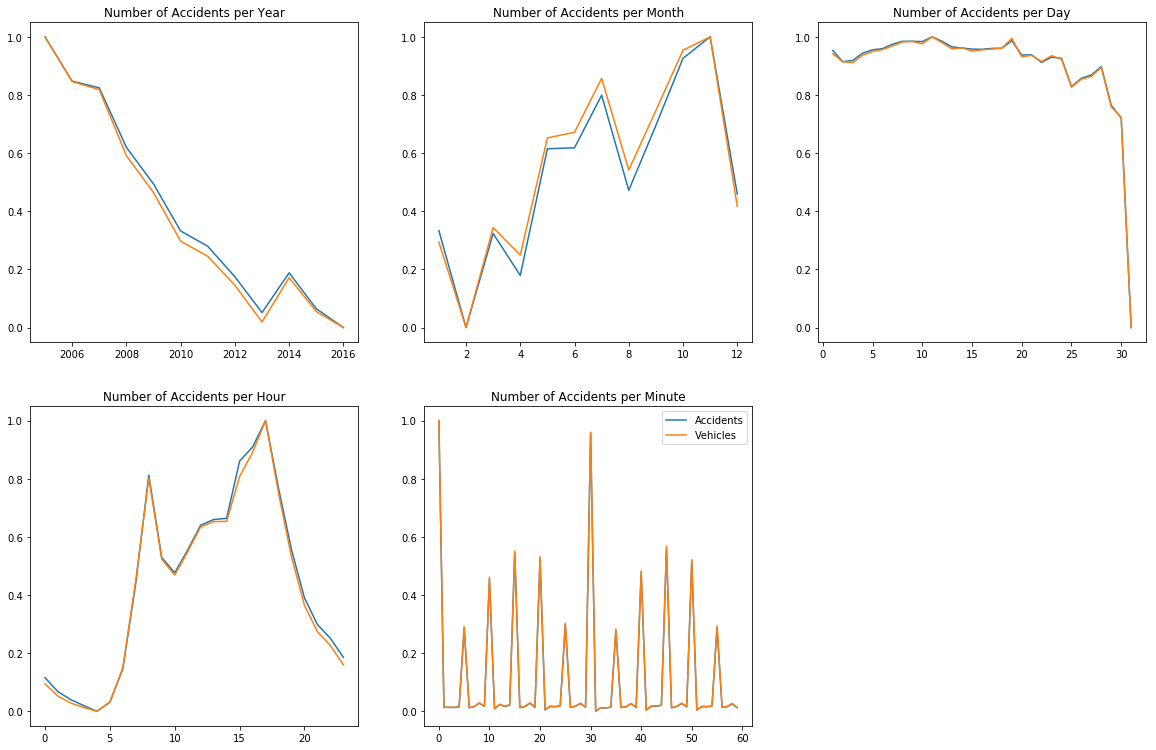

In [18]:
# Analyse DateTime and determine the split to Year, Month, Day, Hour and Minute 
# to determine if the split shows interesting patterns
def dt_general_plotter(ax, data, by, label, scaler = MinMaxScaler()):
    ax.plot(*zip(*[
        (yr, cnt[0])
        for yr, cnt in zip(range(min(by), max(by) + 1), 
                           scaler.fit_transform(np.array(data.groupby(by).count()).reshape(-1, 1)))
    ]), label = label)
    
veh_ind = pd.DataFrame({
    'Accident_Index': veh['Accident_Index']
}).merge(acc.loc[:, ('Accident_Index', 'Date_Time')], on = 'Accident_Index', how = 'inner')
scaler = MinMaxScaler()
hold = 'Accident_Index'
dtm = 'Date_Time'

fig = plt.figure(figsize=[20,20])
nrow, ncol, ind = 3, 3, 1

# Year
ax = fig.add_subplot(nrow, ncol, ind)
dt_general_plotter(ax, acc[hold], acc[dtm].dt.year, 'Accidents', scaler)
dt_general_plotter(ax, veh_ind[hold], veh_ind[dtm].dt.year, 'Vehicles', scaler)
ax.set_title('Number of Accidents per Year')
ind += 1

# Month
ax = fig.add_subplot(nrow, ncol, ind)
dt_general_plotter(ax, acc[hold], acc[dtm].dt.month, 'Accidents', scaler)
dt_general_plotter(ax, veh_ind[hold], veh_ind[dtm].dt.month, 'Vehicles', scaler)
ax.set_title('Number of Accidents per Month')
ind += 1

# Day
ax = fig.add_subplot(nrow, ncol, ind)
dt_general_plotter(ax, acc[hold], acc[dtm].dt.day, 'Accidents', scaler)
dt_general_plotter(ax, veh_ind[hold], veh_ind[dtm].dt.day, 'Vehicles', scaler)
ax.set_title('Number of Accidents per Day')
ind += 1

# Hour
ax = fig.add_subplot(nrow, ncol, ind)
dt_general_plotter(ax, acc[hold], acc[dtm].dt.hour, 'Accidents', scaler)
dt_general_plotter(ax, veh_ind[hold], veh_ind[dtm].dt.hour, 'Vehicles', scaler)
ax.set_title('Number of Accidents per Hour')
ind += 1

# Minute
ax = fig.add_subplot(nrow, ncol, ind)
dt_general_plotter(ax, acc[hold], acc[dtm].dt.minute, 'Accidents', scaler)
dt_general_plotter(ax, veh_ind[hold], veh_ind[dtm].dt.minute, 'Vehicles', scaler)
ax.set_title('Number of Accidents per Minute')
ind += 1

plt.legend()
plt.show()

In [19]:
# Only Minute has no useful pattern as its an interval of 5 minutes.
# Day is already included as acc.Day_of_Week
acc['Year'], acc['Month'], acc['Hour'] = acc['Date_Time'].dt.year, acc['Date_Time'].dt.month, acc['Date_Time'].dt.hour

In [20]:
# Odd or questionable records caught during analysis which are removed later are placed in this cell
# Speed_Limit == 0 record, makes no sense to have any road with 0 speed limit
acc.drop(acc[acc['Speed_Limit'] == 0].index, inplace=True)
veh = drop_records_after(acc, veh)

# Missing data analysis Stage 1

In [21]:
def plot_yearly_missing_data_cols(data, fig, nrow = -1, ncol = 3, ind = 1):
    missing_cols = sorted([(x, col) for col, x in zip(data.columns, data.isnull().sum(axis=0).tolist()) if x > 0])
    if nrow < 0:
        nrow = np.ceil(len(missing_cols) / 3)

    for (x, col) in missing_cols:
        ax = fig.add_subplot(nrow, ncol, ind)
        missing_group = data.loc[:, ('Year', col)].groupby('Year').apply(lambda x: x.loc[x[col].isnull(), 'Year'].count())
        ax.bar(*zip(*[(ind, val) for ind, val in zip(missing_group.index, missing_group)]))
        ax.set_title(col.replace('_', ' '))
        ax.set_xlabel('Year')
        ax.set_ylabel('Frequency')
        ind += 1

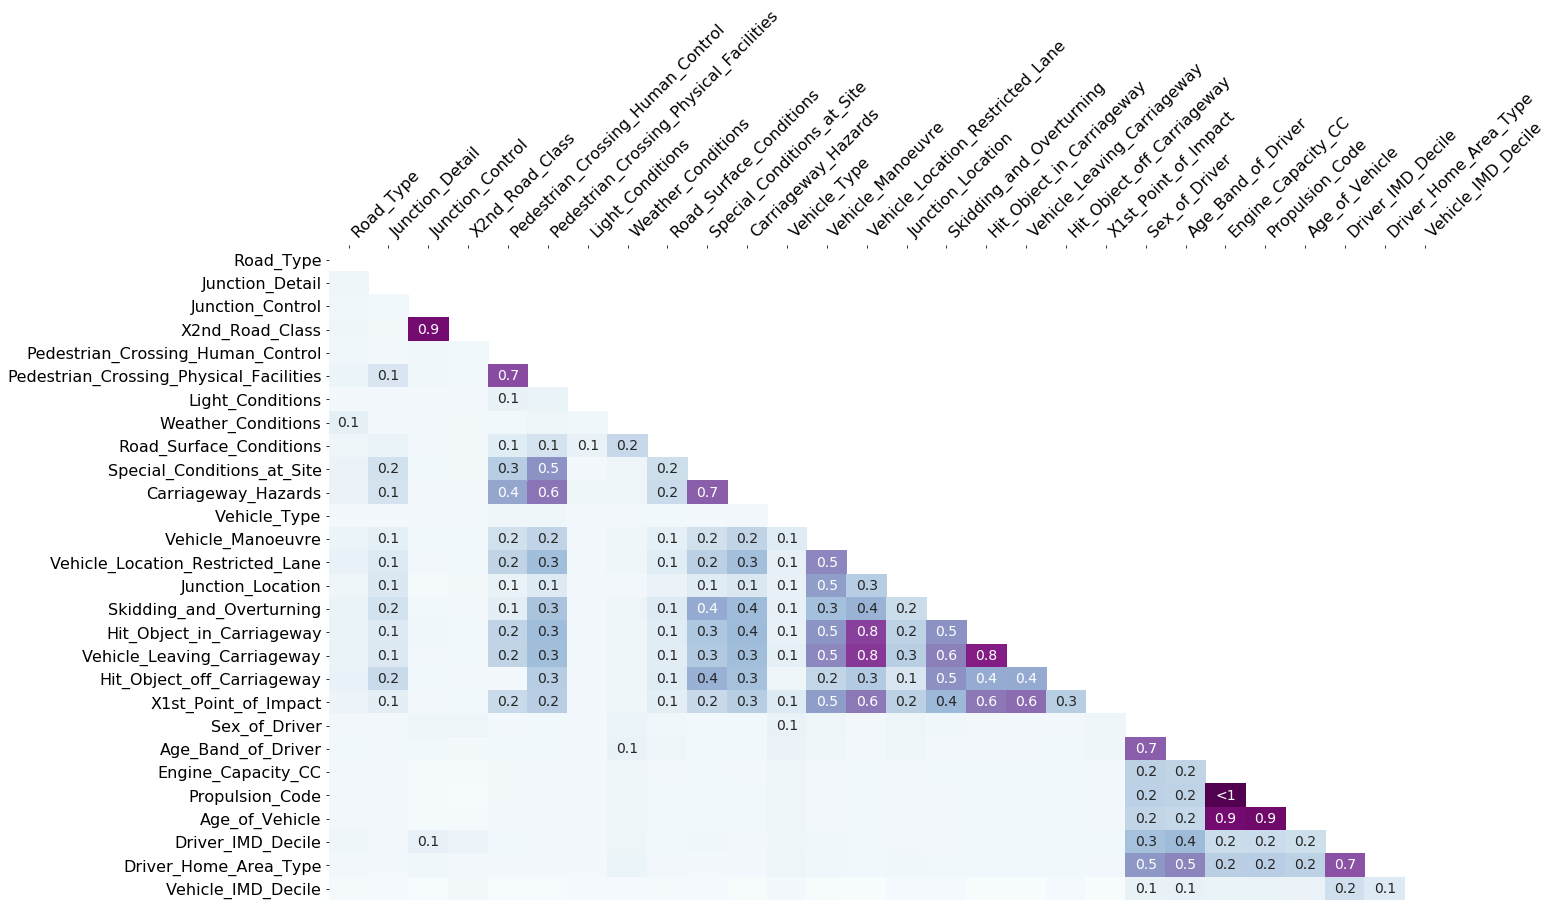

In [22]:
msno.heatmap(acc.merge(veh, on = 'Accident_Index', how = 'inner'), cmap='BuPu')

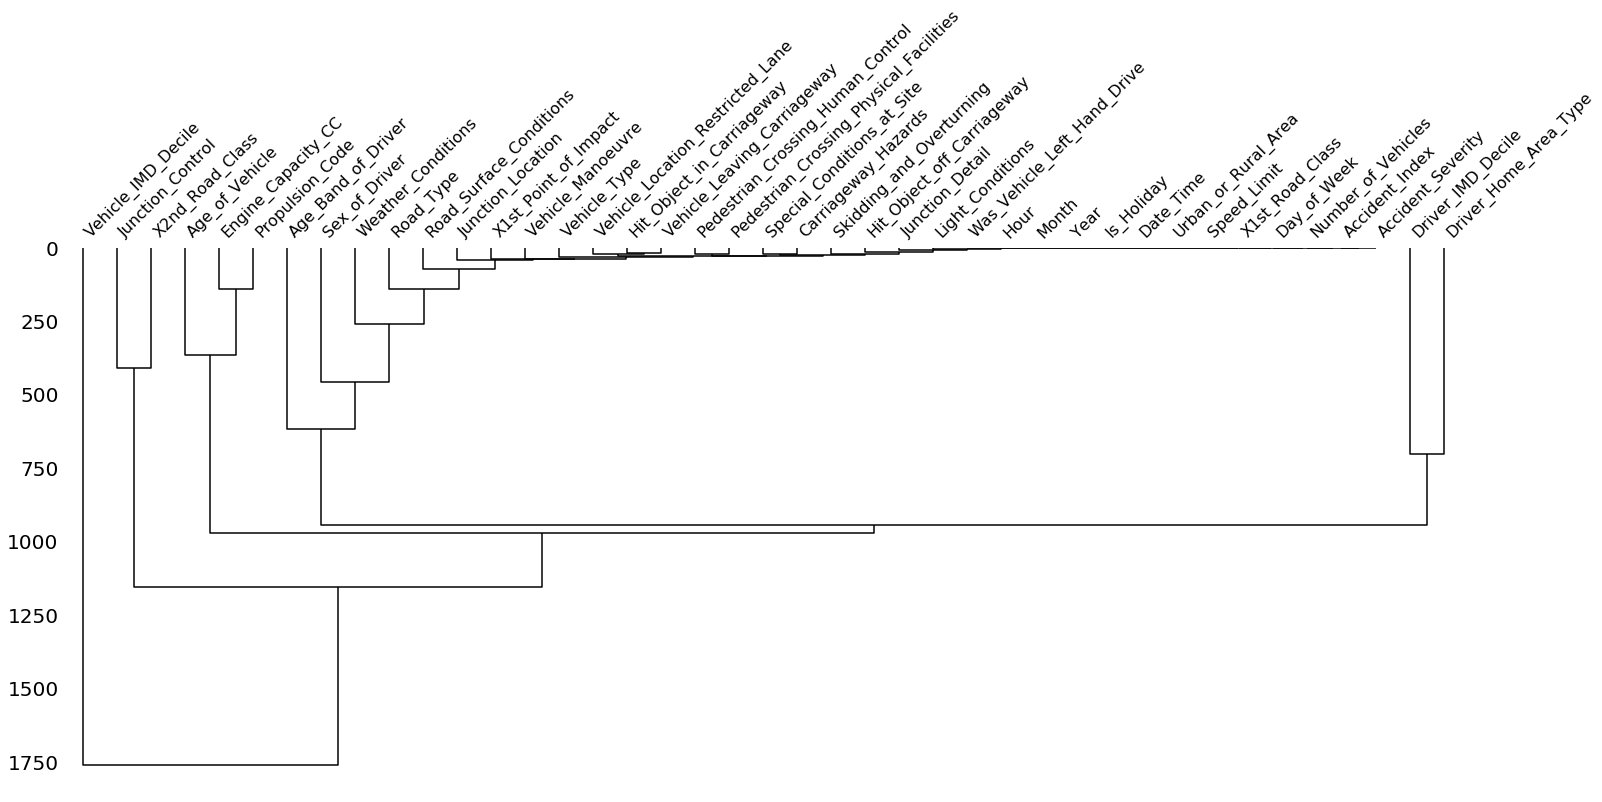

In [23]:
msno.dendrogram(acc.merge(veh, on = 'Accident_Index', how = 'inner'))

In [24]:
# Junction_Control and X2nd_Road_Class has pretty dramatic missing values, look into it more deeply
[(col, x, round((x/len(acc)) * 100, 2)) for col, x in zip(acc.columns, acc.isnull().sum(axis=0).tolist()) if x > 0]

[('Road_Type', 11473, 0.6),
 ('Junction_Detail', 49, 0.0),
 ('Junction_Control', 694815, 36.51),
 ('X2nd_Road_Class', 783378, 41.17),
 ('Pedestrian_Crossing_Human_Control', 329, 0.02),
 ('Pedestrian_Crossing_Physical_Facilities', 499, 0.03),
 ('Light_Conditions', 10, 0.0),
 ('Weather_Conditions', 37680, 1.98),
 ('Road_Surface_Conditions', 2921, 0.15),
 ('Special_Conditions_at_Site', 304, 0.02),
 ('Carriageway_Hazards', 382, 0.02)]

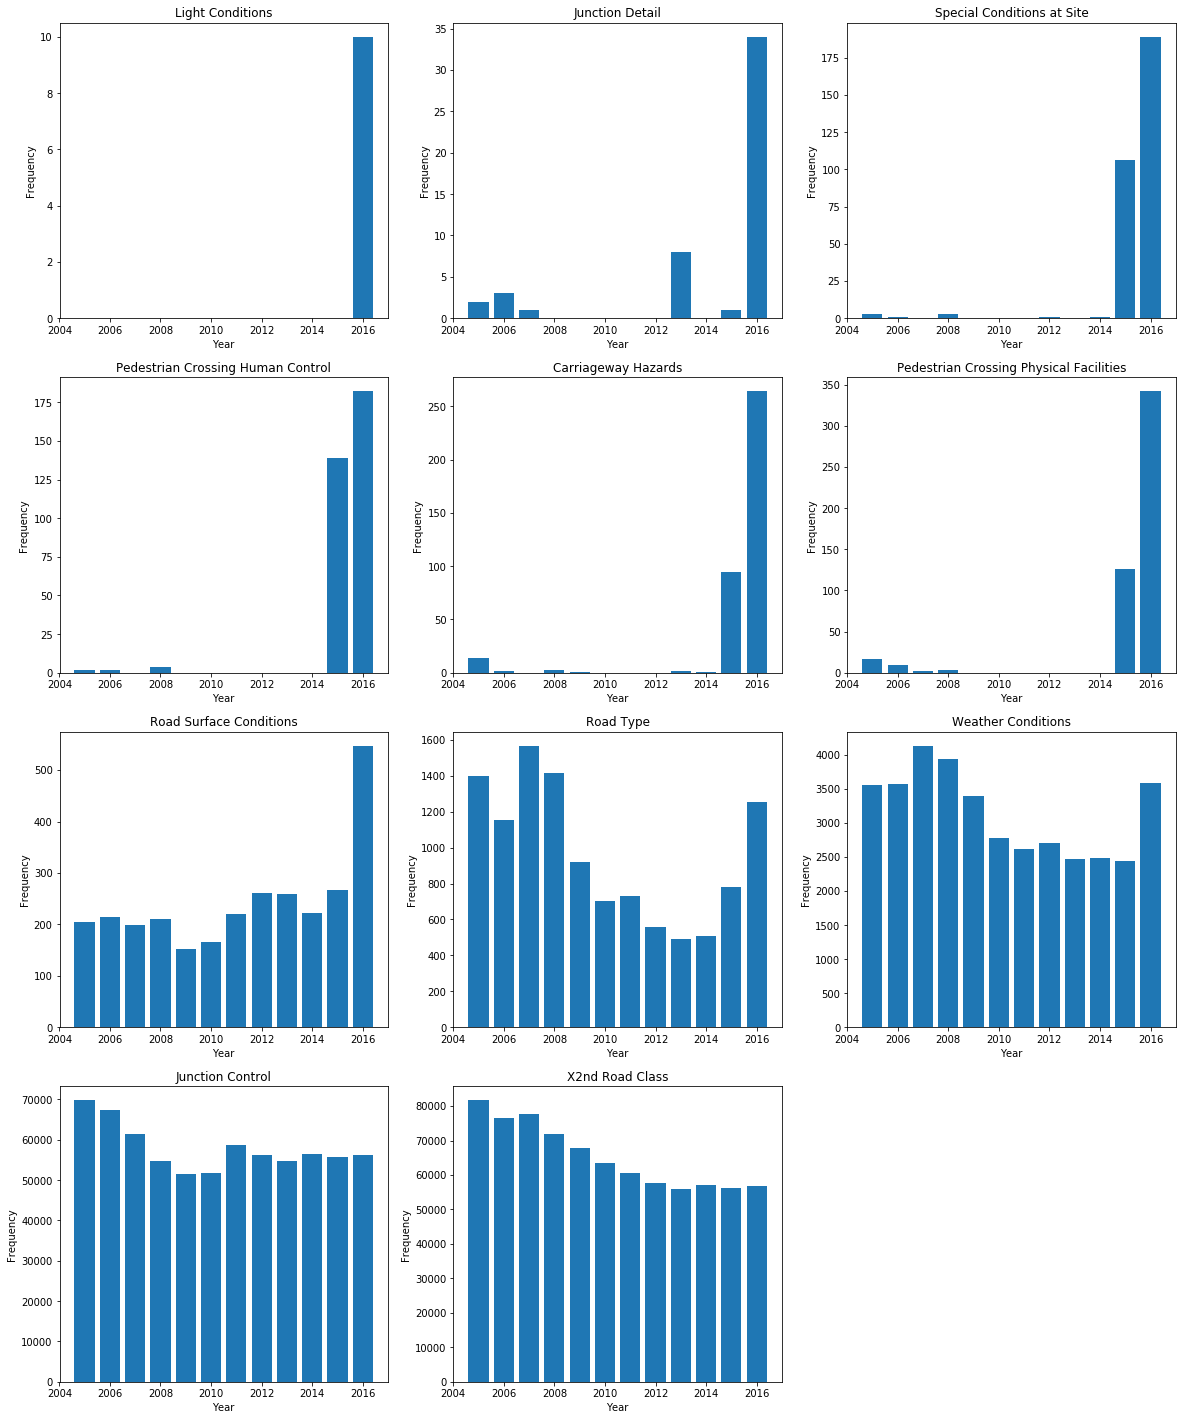

In [25]:
# How many are missing each year? Maybe survey is different by year
plot_yearly_missing_data_cols(data = acc, fig = plt.figure(figsize=[20,25]))

plt.show()

In [26]:
[(col, x, round((x/len(veh)) * 100, 2)) for col, x in zip(veh.columns, veh.isnull().sum(axis=0).tolist()) if x > 0]

[('Vehicle_Type', 833, 0.02),
 ('Vehicle_Manoeuvre', 1401, 0.04),
 ('Vehicle_Location_Restricted_Lane', 849, 0.02),
 ('Junction_Location', 1694, 0.05),
 ('Skidding_and_Overturning', 485, 0.01),
 ('Hit_Object_in_Carriageway', 847, 0.02),
 ('Vehicle_Leaving_Carriageway', 867, 0.02),
 ('Hit_Object_off_Carriageway', 201, 0.01),
 ('X1st_Point_of_Impact', 1540, 0.04),
 ('Sex_of_Driver', 207012, 5.93),
 ('Age_Band_of_Driver', 387083, 11.1),
 ('Engine_Capacity_CC', 910546, 26.1),
 ('Propulsion_Code', 891224, 25.55),
 ('Age_of_Vehicle', 1015460, 29.11),
 ('Driver_IMD_Decile', 1167486, 33.47),
 ('Driver_Home_Area_Type', 676917, 19.41),
 ('Vehicle_IMD_Decile', 3304001, 94.72)]

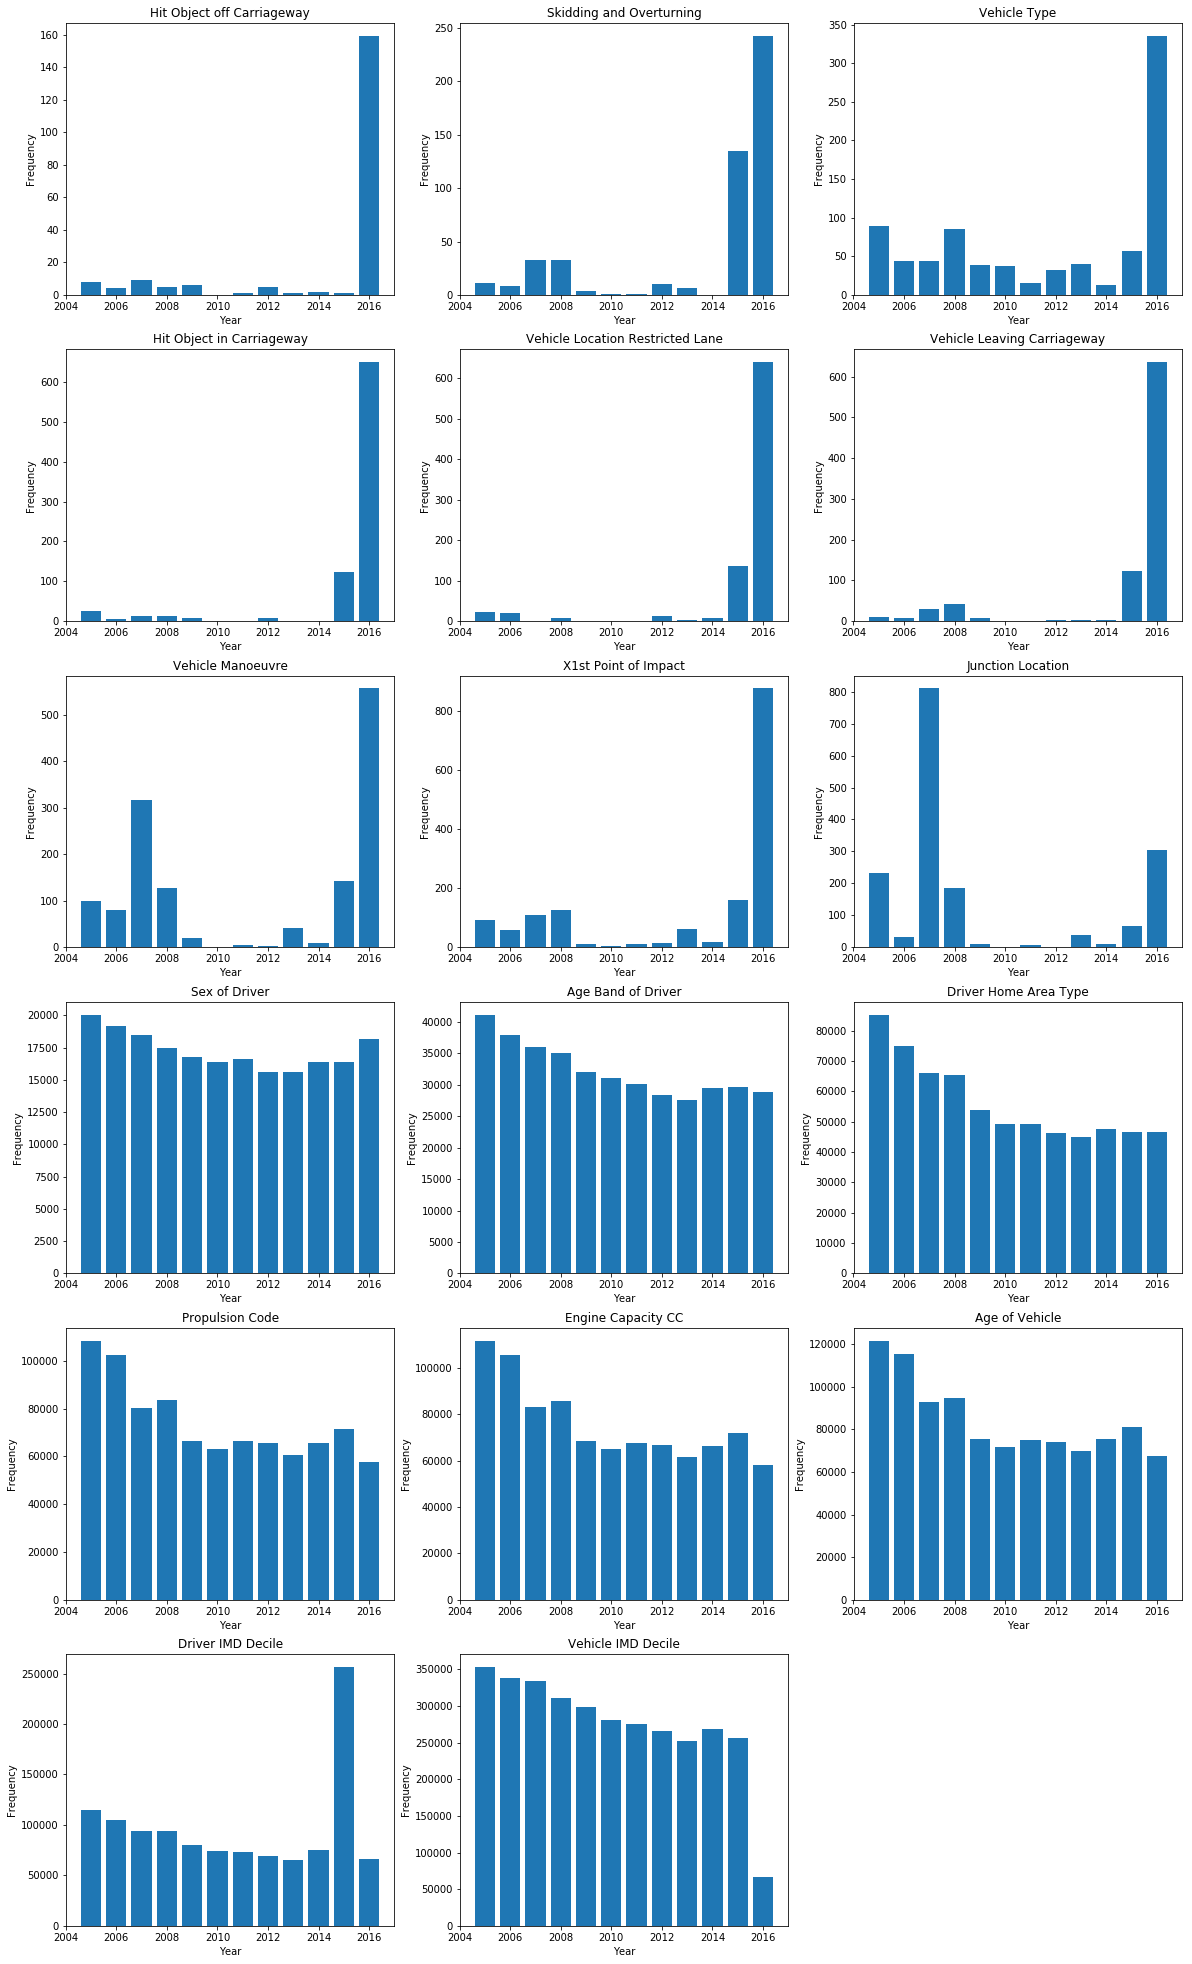

In [27]:
plot_yearly_missing_data_cols(data = veh.merge(acc.loc[:, ('Accident_Index', 'Year')], on = 'Accident_Index', how = 'inner'), 
                              fig = plt.figure(figsize=[20, 35]))
plt.show()

In [28]:
# Remove features with > 10% missing data
# The rest will be imputed with R Mice
acc.drop(['Junction_Control', 'X2nd_Road_Class'], axis=1, inplace=True)
veh.drop(['Age_Band_of_Driver', 'Engine_Capacity_CC', 'Propulsion_Code', 'Age_of_Vehicle', 'Driver_IMD_Decile',
         'Driver_Home_Area_Type', 'Vehicle_IMD_Decile'], axis=1, inplace=True)

# Analysis Stage 1

In [29]:
# Plot Pearson correlation coefficient
def plot_pearsonr(data):
    corr = data.copy().corr()
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(20, 20))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [30]:
target = acc['Accident_Severity'].copy()
veh_ga1 = veh.merge(acc.loc[:, ('Accident_Index', 'Year', 'Accident_Severity')], on = 'Accident_Index', how = 'inner')

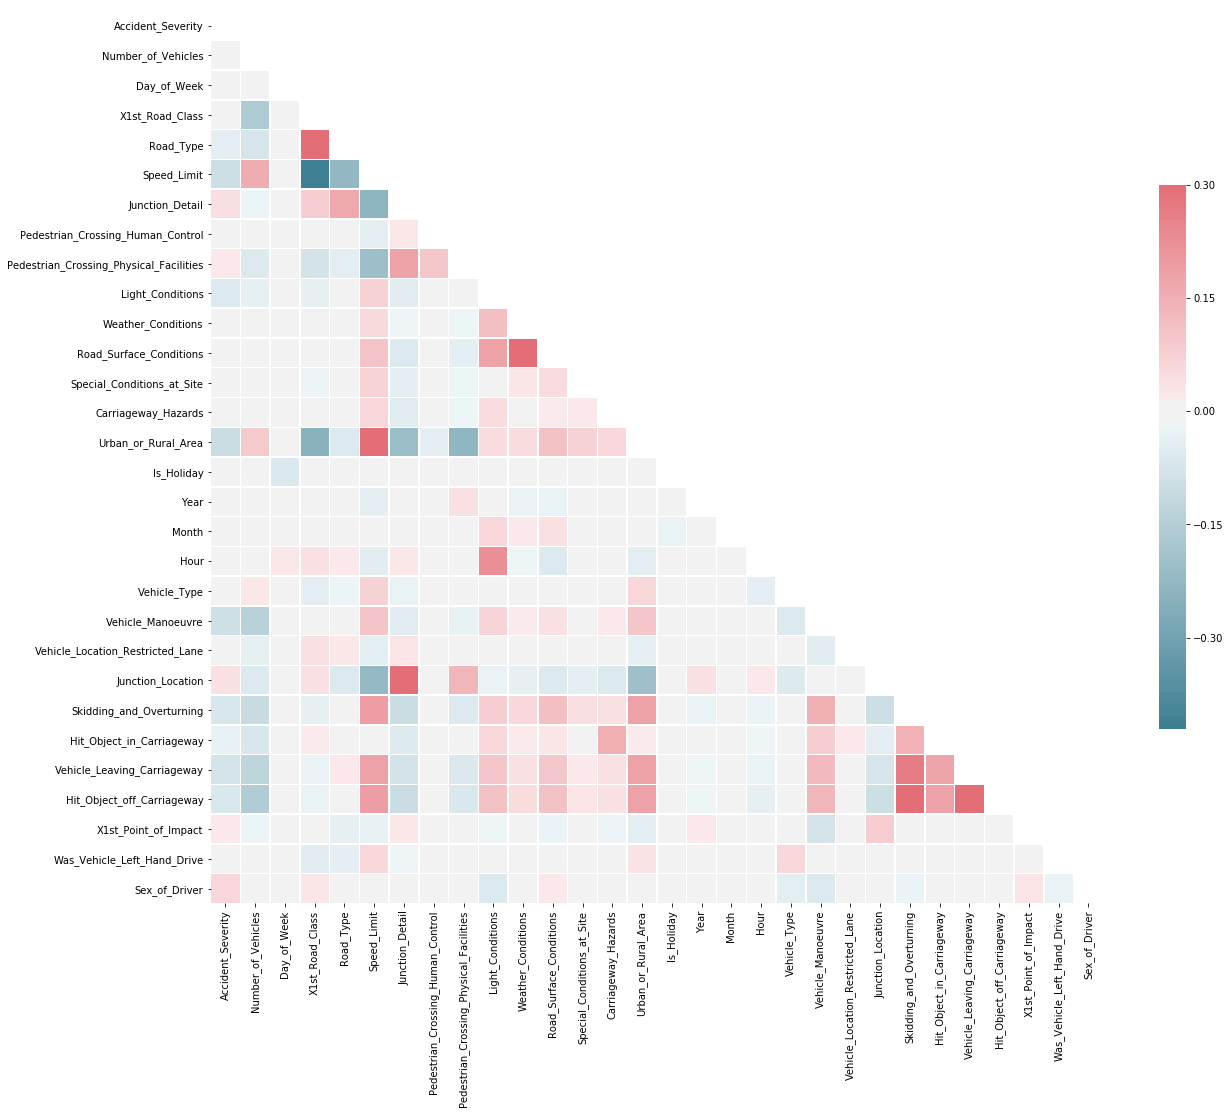

In [31]:
plot_pearsonr(acc.merge(veh, on = 'Accident_Index'))

In [32]:
# Plot a global mean horizontal line on a line plot for labels freater than min_label
# Otherwise, plot a histogram of counts per label on select_col
def plot_mean_relation_with(data, fig, select_col, nrow = -1, ncol = 3, ind = 1, exclusion_list = None, min_label = 5):
    if not isinstance(select_col, str):
        print('Only 1 feature can be selected')
        return
    if select_col not in data.columns:
        print('Selected column must contain in the dataframe')
        return
    data_cols = data.columns.drop(select_col) if exclusion_list is None else data.columns.drop(exclusion_list + [select_col])
    if nrow < 0:
        nrow = np.ceil(len(data_cols) / ncol) + 2
    global_mean = data[select_col].mean()
    
    countplot_cols = list()
    for col in data_cols:
        if len(pd.unique(data[col])) > min_label:
            ax = fig.add_subplot(nrow, ncol, ind)
            ax.plot(data.loc[:, (col, select_col)].groupby(col).mean())
            ax.axhline(global_mean, color = 'r', linestyle = '--')
        else:
            countplot_cols.append(col)
            continue
        ax.set_title(col.replace('_', ' '))
        if len(data_cols) - len(countplot_cols) - ind <= ncol + len(countplot_cols):
            ax.set_xlabel('Label')
        if ind % ncol == 1:
            ax.set_ylabel(select_col + ' (Mean)')
        ind += 1

    if (ind - 1) % ncol != 0:
        ind += (ind % ncol) + 1
    
    for col in countplot_cols:
        ax = fig.add_subplot(nrow, ncol, ind)
        sns.countplot(data = data, ax = ax, x = col, hue = select_col)
        ind += 1
        
def plot_lv_relation_with(data, fig, dv, hue = None, nrow = -1, ncol = 3, ind = 1, exclusion_list = None, 
                         orient = 'v'):
    if not isinstance(dv, str):
        print('Independant variable must be single feature')
        return
    data_cols = data.columns.drop(dv) if exclusion_list is None else data.columns.drop(exclusion_list + [dv])
    if nrow < 0:
        nrow = np.ceil(len(data_cols) / ncol) + 2
    
    for col in data_cols:
        ax = fig.add_subplot(nrow, ncol, ind)
        if hue is not None:
            sns.lvplot(data = data, x = col, y = dv, hue = hue, ax = ax, orient = orient)
        else:
            sns.lvplot(data = data, x = col, y = dv, ax = ax, orient = orient)
        if ind % ncol != 1:
            ax.set_ylabel('')
        ind += 1
    sns.despine()

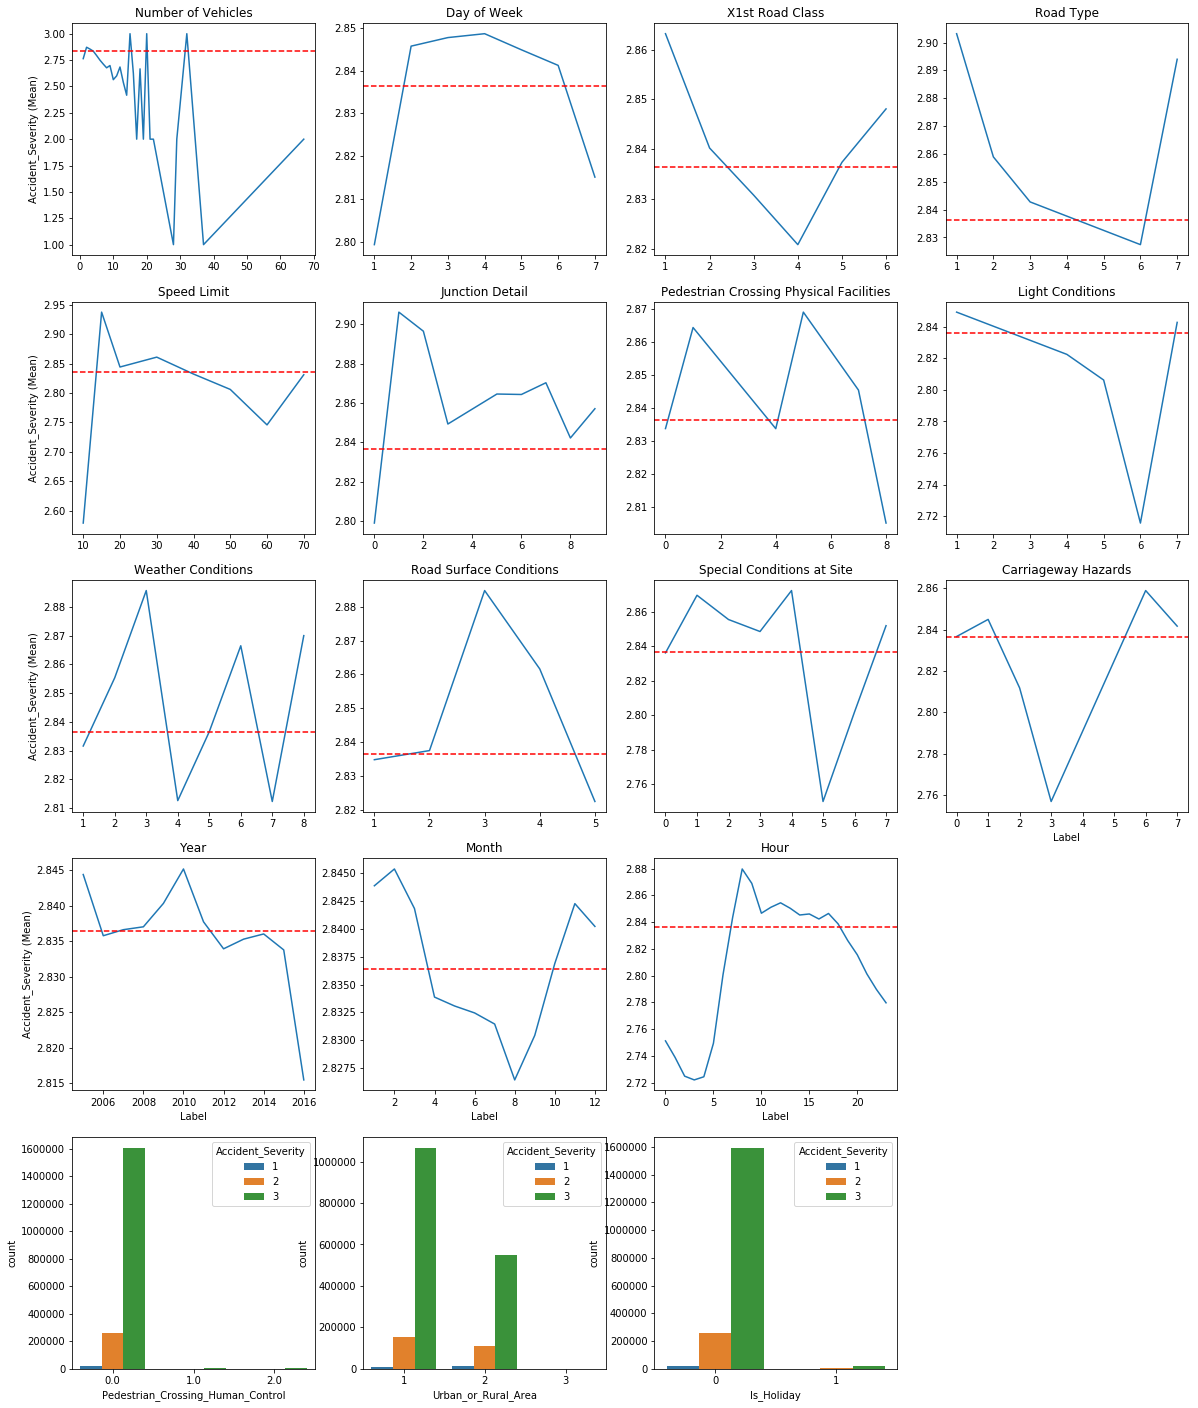

In [33]:
plot_mean_relation_with(data = acc, fig = plt.figure(figsize=[20,35]), select_col = 'Accident_Severity', 
                       exclusion_list = ['Accident_Index', 'Date_Time'], ncol = 4)
plt.show()

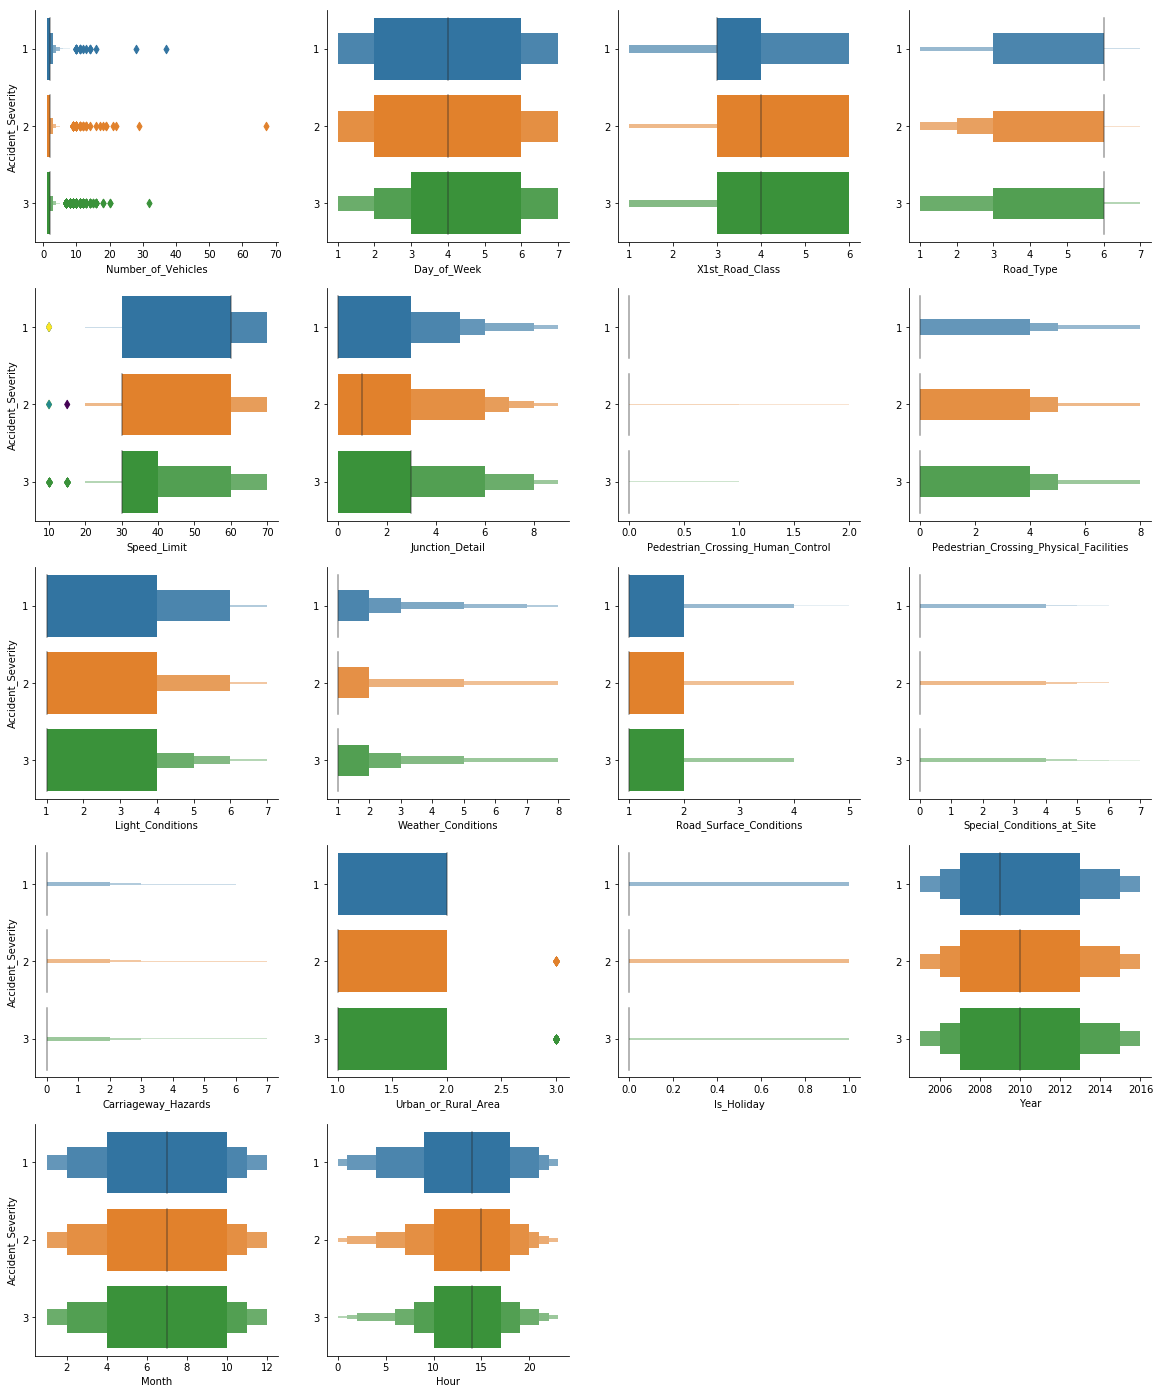

In [34]:
plot_lv_relation_with(data = acc, fig = plt.figure(figsize=[20,35]), dv = 'Accident_Severity', orient = 'h', 
                       exclusion_list = ['Accident_Index', 'Date_Time'], ncol = 4)

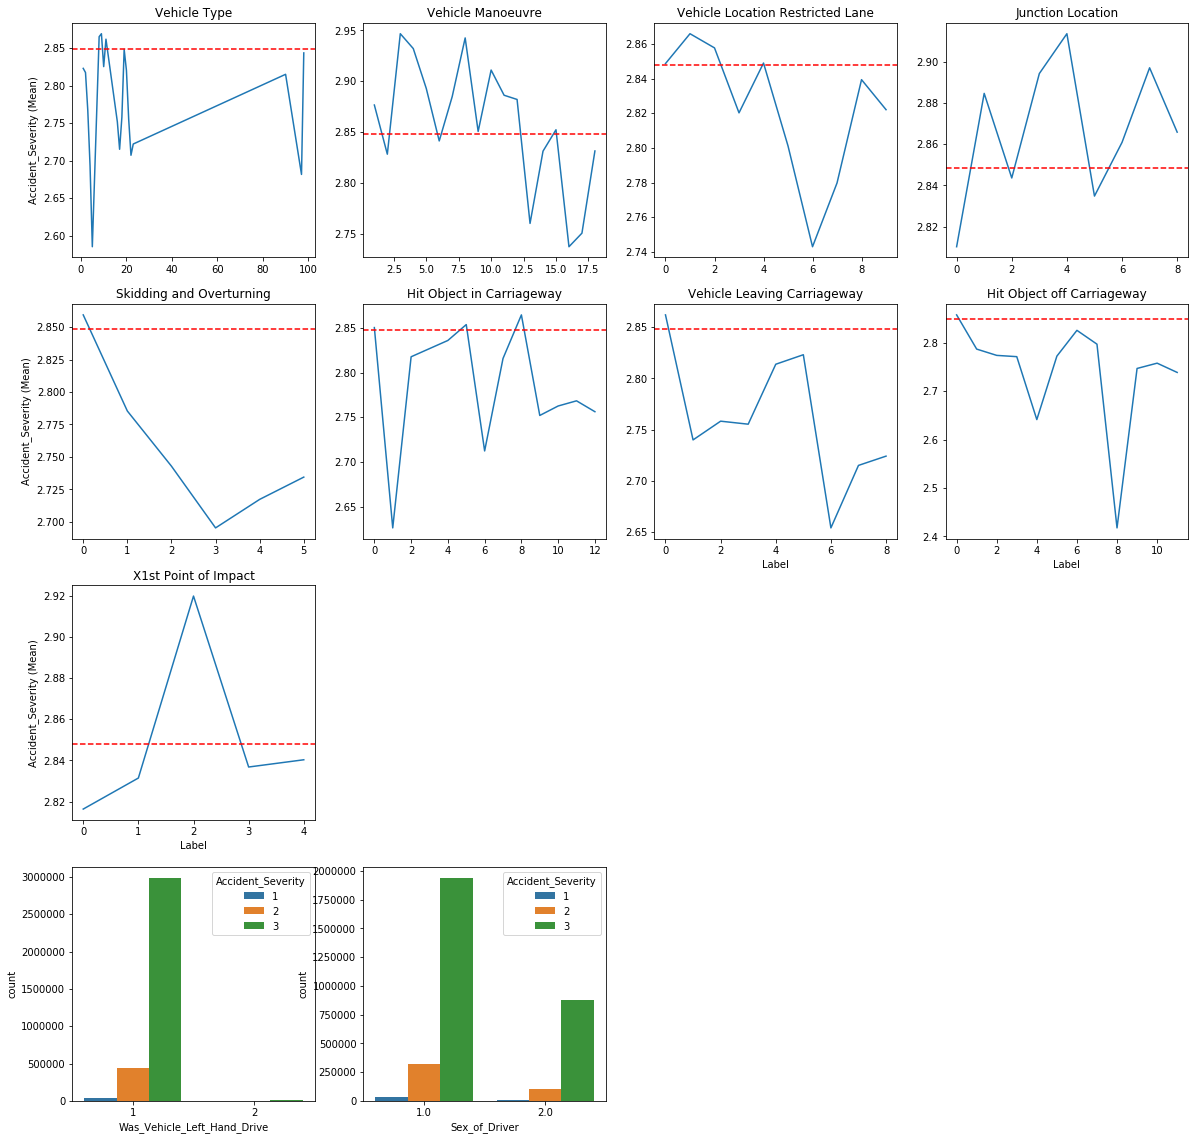

In [35]:
plot_mean_relation_with(data = veh_ga1, fig = plt.figure(figsize=[20,25]), select_col = 'Accident_Severity', 
                       exclusion_list = ['Accident_Index', 'Year'], ncol = 4)
plt.show()

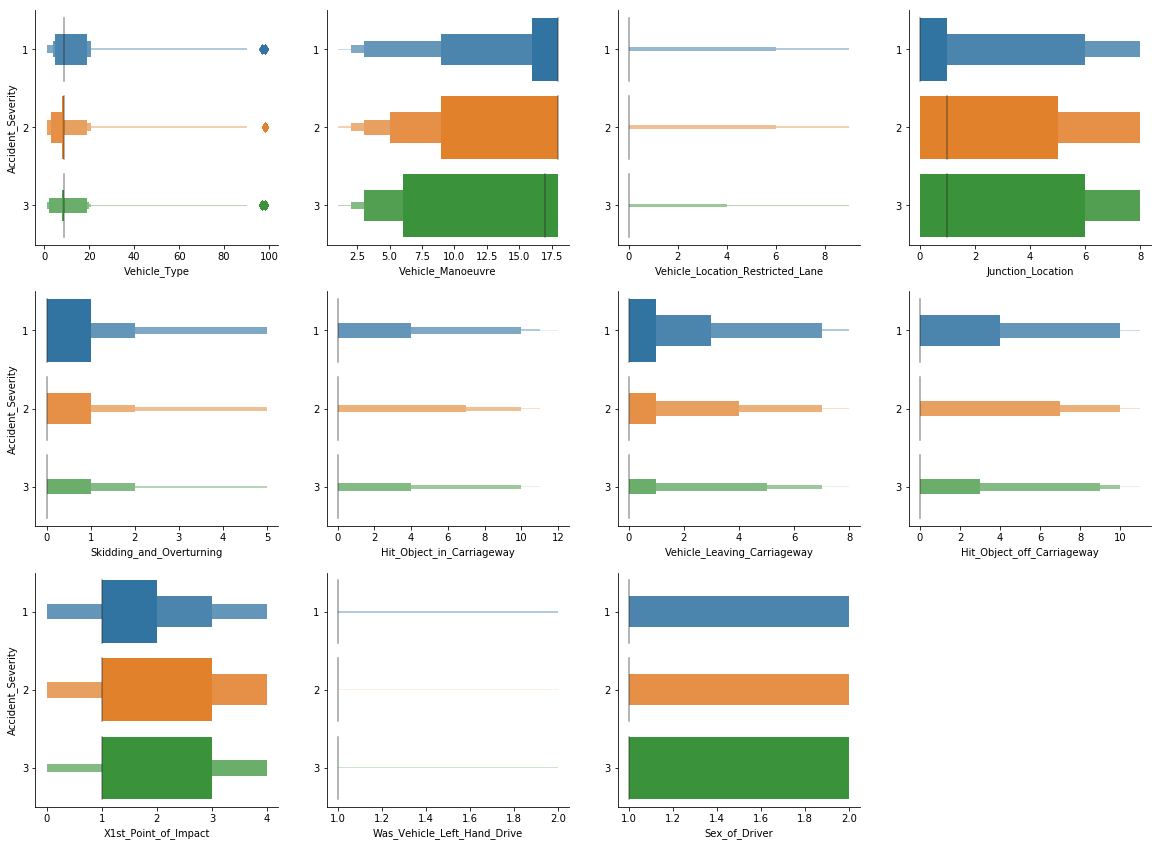

In [36]:
plot_lv_relation_with(data = veh_ga1, fig = plt.figure(figsize=[20,25]), dv = 'Accident_Severity', orient = 'h', 
                       exclusion_list = ['Accident_Index', 'Year'], ncol = 4)

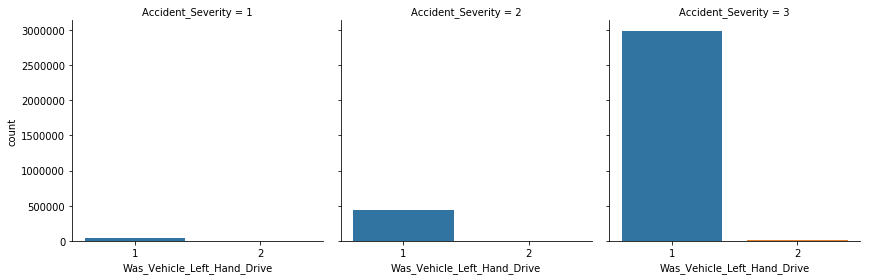

In [37]:
sns.factorplot(data = veh_ga1, kind = 'count', col = 'Accident_Severity', x = 'Was_Vehicle_Left_Hand_Drive')

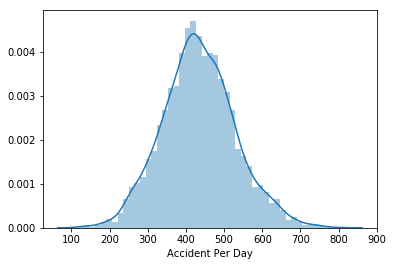

In [38]:
sns.distplot(acc.groupby(['Year', 'Month', acc['Date_Time'].dt.day]).count()['Accident_Index'], axlabel='Accident Per Day')

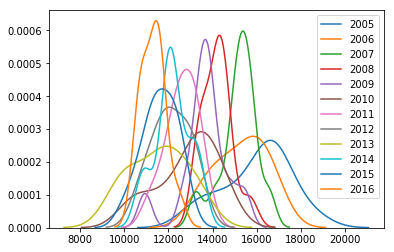

In [39]:
tmp = acc.groupby(['Year', 'Month']).count()['Accident_Index']

for yr in pd.unique(acc['Year']):
    sns.kdeplot(tmp[yr], label=str(yr))

In [40]:
acc_imp = pd.read_csv('Imputation/2.3/acc2005_2016-v2018.2.3.imp.csv')
veh_imp = pd.read_csv('Imputation/2.3/veh2005_2016-v2018.2.3.imp.csv')
chi = chi2(acc_imp.merge(veh_imp, on = 'Accident_Index', how = 'inner').drop([
    'Accident_Index', 'Accident_Severity', 'Date_Time'], axis = 1), acc_imp.merge(veh_imp, 
                                                                                  on = 'Accident_Index', how = 'inner')['Accident_Severity'])
tap_cols = acc_imp.merge(veh_imp, on = 'Accident_Index', how = 'inner').columns.drop(['Accident_Index', 'Date_Time', 'Accident_Severity'])
tmp = [(x, y, z) for x, y, z in zip(tap_cols, chi[0], chi[1])]

In [41]:
tmp

[('Day_of_Week', 56.96877645957535, 4.259781973895964e-13),
 ('Is_Holiday', 175.49265088189668, 7.802882258961945e-39),
 ('Year', 10.818407904819006, 0.0044752012669609645),
 ('Month', 116.79056799274166, 4.357630391694904e-26),
 ('Hour', 666.4384985004003, 1.926277210947239e-145),
 ('X1st_Road_Class', 2111.909631473518, 0.0),
 ('Road_Type', 3519.9486822011636, 0.0),
 ('Pedestrian_Crossing_Human_Control',
  188.82208830677519,
  9.949574160971437e-42),
 ('Light_Conditions', 17167.65684961042, 0.0),
 ('Weather_Conditions', 537.4978620377314, 1.9223047589690178e-117),
 ('Road_Surface_Conditions', 99.86588330182943, 2.0625238338258642e-22),
 ('Special_Conditions_at_Site', 235.83298722690483, 6.159103444556743e-52),
 ('Carriageway_Hazards', 506.36858161267804, 1.1052476450261926e-110),
 ('Urban_or_Rural_Area', 6036.4644326489815, 0.0),
 ('Vehicle_Type', 13830.453163885863, 0.0),
 ('Vehicle_Manoeuvre', 86007.79286967302, 0.0),
 ('Skidding_and_Overturning', 35894.27637987831, 0.0),
 ('X1st_P

In [42]:
tmp = acc.loc[:, ('Accident_Index', 'Accident_Severity')].groupby('Accident_Severity').count()
for i in tmp['Accident_Index']:
    print('{}: {:.2f}'.format(i, i * 100 / len(acc)))

24498: 1.29
262292: 13.78
1616040: 84.93


In [43]:
tmp['Accident_Index']

Accident_Severity
1      24498
2     262292
3    1616040
Name: Accident_Index, dtype: int64

# Feature Selection Stage 1
## Use backward elimination by recursively fitting LDA
 - 5 different solvers are used:
  - Single value decomposition
  - Least Square
  - Eigen
  - Least Square with shrinkage
  - Eigen with shrinkage
 - The best features are selected by fitting the resulting feature set with a Random Forest of 30 trees

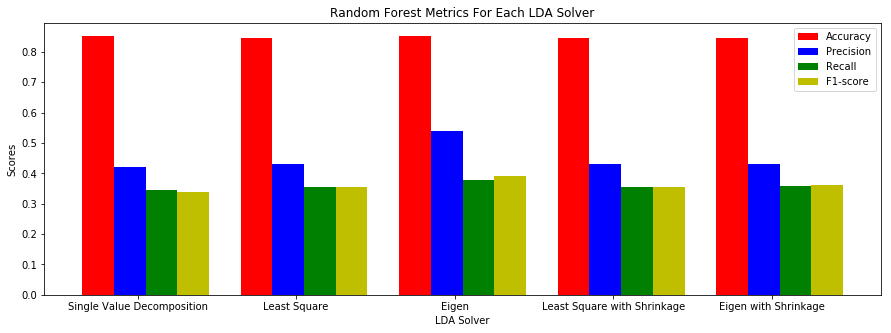

In [45]:
fs_res = joblib.load('lda-rfe-fs1-res.pkl')
N = len(fs_res)
ind = np.arange(N)
width = 0.2

fig, ax = plt.subplots(figsize=[15,5])

rects = [
    ax.bar(ind - width, [fs['ACC'] for _, fs in fs_res.items()], width=width, color='r'),
    ax.bar(ind, [fs['PRF1'][0] for _, fs in fs_res.items()], width=width, color='b'),
    ax.bar(ind + width, [fs['PRF1'][1] for _, fs in fs_res.items()], width=width, color='g'),
    ax.bar(ind + width * 2, [fs['PRF1'][2] for _, fs in fs_res.items()], width=width, color='y')
]

# add some text for labels, title and axes ticks
ax.set_xlabel('LDA Solver')
ax.set_ylabel('Scores')
ax.set_xticks(ind + width / len(rects))
ax.set_xticklabels(('Single Value Decomposition', 'Least Square', 'Eigen', 'Least Square with Shrinkage', 'Eigen with Shrinkage'))
ax.set_title('Random Forest Metrics For Each LDA Solver')
ax.legend([r[0] for r in rects], ['Accuracy', 'Precision', 'Recall', 'F1-score'])

# def autolabel(rects):
#     """
#     Attach a text label above each bar displaying its height
#     """
#     for rect in rects:
#         height = rect.get_height()
#         ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
#                 '%d' % int(height),
#                 ha='center', va='bottom')
        
# for r in rects:
#     autolabel(r)

plt.show()

In [46]:
# Retrieve the selected 20 features
fs_col = joblib.load('lda-rfe-fs1.pkl')
tap_col = joblib.load('lda-rfe-tap_col.pkl')

sel_feat = pd.Series(tap_col[fs_col['lda-rfe-eigen'].support_].tolist() + ['Accident_Index', 'Accident_Severity', 'Date_Time'])

# Copy the selected features
acc_sel1 = acc.loc[:, acc.columns.isin(sel_feat)].copy()
veh_sel1 = veh.loc[:, veh.columns.isin(sel_feat)].copy()

FileNotFoundError: [Errno 2] No such file or directory: 'lda-rfe-tap_col.pkl'

# Missing data analysis Stage 2

In [ ]:
tap_sel1 = acc_sel1.merge(veh_sel1, on = 'Accident_Index', how = 'inner')

In [ ]:
msno.matrix(tap_sel1)

In [ ]:
plot_pearsonr(tap_sel1)

In [ ]:
msno.heatmap(tap_sel1, cmap='BuPu')

In [ ]:
msno.dendrogram(tap_sel1)

In [ ]:
# Inspect row wise missing values
tmp = acc_sel1.isnull().sum(axis=1)
min_tmp = min(tmp)
min_tmp = min_tmp if min_tmp > 0 else 1

for i in range(min_tmp, max(tmp) + 1):
    print(i, ':', len(list(filter(lambda x: x == i, tmp))))

# # Before we inspect missing valued features in detail, remove any records with > 3 missing values
# acc_sel1.dropna(thresh=len(acc_sel1.columns) - 3, inplace=True)
# # Make Vehicles dataset consistent
# veh.drop(veh.index[veh.set_index('Accident_Index').index.isin(acc.set_index('Accident_Index').index) ^ True], 
#          axis=0, inplace=True)

In [ ]:
# Inspect row wise missing values
tmp = veh_sel1.isnull().sum(axis=1)
min_tmp = min(tmp)
min_tmp = min_tmp if min_tmp > 0 else 1

veh_ind = list()

for i in range(min_tmp, max(tmp) + 1):
    print(i, ':', len(list(filter(lambda x: x == i, tmp))))
    if i > 3:
        veh_ind.append(veh_sel1.loc[tmp == i, 'Accident_Index'].tolist())
veh_ind = list(set(list(chain(*veh_ind))))

# veh_sel1.drop(veh_sel1.index[veh_sel1.set_index('Accident_Index').index.isin(veh_ind) ^ False], axis=0, inplace=True)
# acc_sel1.drop(acc_sel1.index[acc_sel1.set_index('Accident_Index').index.isin(veh_sel1.set_index('Accident_Index').index) ^ True], 
#          axis=0, inplace=True)

In [ ]:
# Inspect column wise missing values in detail
[(col, x, round((x/len(acc_sel1)) * 100, 2)) for col, x in zip(acc_sel1.columns, acc_sel1.isnull().sum(axis=0).tolist()) if x > 0]

In [ ]:
# Inspect column wise missing values in detail
[(col, x, round((x/len(veh_sel1)) * 100, 2)) for col, x in zip(veh_sel1.columns, veh_sel1.isnull().sum(axis=0).tolist()) if x > 0]

In [ ]:
tmp_veh = veh_sel1.loc[:, ('Accident_Index', 'Sex_of_Driver')].merge(
    acc_sel1.loc[:, ('Accident_Index', 'Date_Time')], on = 'Accident_Index')['Sex_of_Driver'].groupby(
    tmp_veh['Date_Time'].dt.year)

In [ ]:
tmp_veh.apply(lambda x: x.isnull().sum())

In [ ]:
veh_ind = list(set(veh_sel1.loc[veh_sel1['Sex_of_Driver'].isnull(), 'Accident_Index']))
veh_sel1.drop(veh_sel1.index[veh_sel1.set_index('Accident_Index').index.isin(veh_ind) ^ False], axis=0, inplace=True)
acc_sel1.drop(acc_sel1.index[acc_sel1.set_index('Accident_Index').index.isin(veh_sel1.set_index('Accident_Index').index) ^ True], 
         axis=0, inplace=True)

In [ ]:
acc_sel1.dtypes

In [ ]:
veh_sel1.dtypes